In [167]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 16}
matplotlib.rc('font', **font)
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]

In [2]:
class GN_model:
    def __init__(self, span_len, lam_op, num_lam, nl_cof, disp_cof,  alpha, r_sym, bchrs, grid_sp, n_fig, num_spans):
        self.span_len = span_len
        self.lam_op = lam_op
        self.num_lam = num_lam
        self.nl_cof = nl_cof
        self.disp_cof = disp_cof
        self.alpha = alpha
        self.r_sym = r_sym
        self.bchrs = bchrs
        self.grid_sp = grid_sp
        self.n_fig = n_fig
        self.num_spans = num_spans
        self.freq = 299792458/(self.lam_op*1e-9)
        self.al_lin = np.log((10**(self.alpha/10)))/2 # fibre loss [1/km] 
        self.beta2 = (self.disp_cof*(self.lam_op**2))/(2*np.pi*299792.458) # dispersion coefficient at given wavelength [ps^2/km]
        self.l_eff = (1 - np.exp(-2*self.al_lin*self.span_len ))/(2*self.al_lin) # effective length [km]
        self.l_eff_as = 1/(2*self.al_lin) # the asymptotic effective length [km]  
        self.h = 6.63*1e-34 # Planck's constant [Js]
        self.Bwdm = self.bchrs * self.num_lam ** ( self.bchrs / self.grid_sp )  # channel BW [GHz]
        self.epsilon = 0.3*np.log(1 + ( 6 * self.l_eff_as ) / ( self.span_len * np.arcsinh( 0.5*np.pi**2 * self.beta2 *self.l_eff_as * self.Bwdm**2 )  )  )
    def predict_snr(self, p_ch):
        Gwdm = (1e-3*self.convert_to_lin(p_ch))/(self.bchrs*1e9)  # [W]
        Gnli = (1e24*(8/27)*(self.nl_cof**2)*(Gwdm**3)*(self.l_eff**2) ) /(np.pi*self.beta2*self.l_eff_as)  *  (np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )*self.num_spans**(1 + self.epsilon)                                                                             
        Pase = self.n_fig*self.h*self.freq*(self.convert_to_lin(self.alpha*self.span_len) - 1)*self.bchrs*1e9*self.num_spans       
        Pch = 1e-3*10**(p_ch/10) 
        snr = (Pch/(Pase + Gnli*self.bchrs*1e9))
        snr = self.apply_trx_b2b(snr, 16.5)
        #snr = ( snr**(-1) + (self.convert_to_lin(16.5))**(-1) )**(-1)
        return self.convert_to_db(snr)
    
    def find_pch_opt(self):  # return optimal Pch in dBm
        PchdBm = np.linspace(-6,6,500)  # 500 datapoints for higher resolution of Pch
        numpch = len(PchdBm)
        Pchsw = 1e-3*10**(PchdBm/10)  # convert from dBm to linear units [W]
        Gwdmsw = Pchsw/(self.bchrs*1e9)
        Gnlisw = (1e24*(8/27)*(self.nl_cof**2)*(Gwdmsw**3)*(self.l_eff**2) ) /(np.pi*self.beta2*self.l_eff_as)  *  (np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )                                                                            
        G = self.alpha*self.span_len
        NFl = 10**(self.n_fig/10) # convert to linear noise figure
        Gl = 10**(G/10) # convert to linear gain
        Pasesw = NFl*self.h*self.freq*(Gl - 1)*self.bchrs*1e9 # [W] the ASE noise power in one Nyquist channel across all spans
        snrsw = (Pchsw)/(Pasesw*np.ones(numpch) + Gnlisw*self.bchrs*1e9)
        return PchdBm[np.argmax(snrsw)]
    
    def apply_trx_b2b(self, snr, snr_pen):
        return ( snr**(-1) + (self.convert_to_lin(16.5))**(-1) )**(-1)
    
    def convert_to_lin(self, x):
        return 10**(x/10)
    
    def convert_to_db(self, x):
        return 10*np.log10(x)

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans 

In [164]:
phys_model = GN_model(100, 1550, 1, 1.1, 18, 0.18, 35, 40.2, 50, 4, 10)

In [144]:
phys_model.find_pch_opt()  # optimal power for a single span (no TRx ) 

-1.7675350701402808

Power shift applied to the data:

In [145]:
 -(1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])

-2.4116161616161618

In [146]:
pch_shifted = pch - (1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
#pch_shifted = pch - (pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])

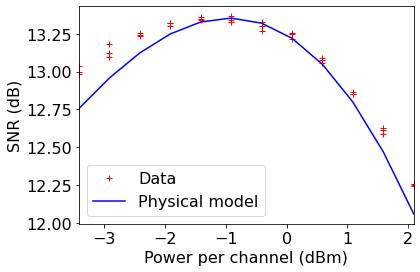

In [169]:
pch_gn = np.linspace(-5, 5, 100)
snr_gn = phys_model.predict_snr(pch_shifted)
#plt.plot(pch, snr, 'g+')
plt.plot(pch_shifted[3:], snr[3:], 'r+', label='Data')
plt.plot(pch_shifted[3:], snr_gn[3:], 'b-', label='Physical model')
plt.xlim([pch_shifted[3], pch_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [170]:
snr_gn_test = phys_model.predict_snr(pch_shifted)
np.mean(((snr_gn_test[3:] - snr[3:])**2)**0.5) # RMSE

0.09291640837463862

In [52]:
pch_gn[np.argmax(phys_model.predict_snr(pch_gn))]

-0.3535353535353538

Still appears to be miles off - could be a case of getting the correct input parameters but the shapes look so different...
Another idea: use the simple model for system performance David uses in his (as yet not accepted) paper:
$SNR^{-1} = {SNR_0}^{-1}\frac{1}{N} \sum_{i=1}^N \frac{2 + p_i^3}{3p_i} + \sigma g $.
* N = number of spans
* $SNR_0$ = estimate of peak SNR 
* p = power divided by the optimal power, such that at $p=p_0$, $SNR = SNR_0$
* g = _N_(0,1)
Note that in this case, the launch powers are uniform so we can replace the sum with multiplying by the number of spans.

NOTE: the Pch readings may be wrong by a constant offset of up to 1 dB! Should try and get agreement with the GN model by shifting the power values (all values by a constant offset). This model is different to the simple model, as it doesn't rely at all on the data but only on a priori knowledge of the data. 

In [63]:
max(snr)

13.365315517943994

In [42]:
class simple_snr_model:
    def __init__(self, num_spans, snr_pk, p_opt, sigma):
        self.num_spans = num_spans
        self.snr_pk = self.convert_to_lin(snr_pk)
        self.p_opt = 1e-3*self.convert_to_lin(p_opt)
        self.sigma = sigma
        print(self.snr_pk)
    
#     def predict_snr(self, p_in):
#         p_in = 1e-3*self.convert_to_lin(p_in)
#         p_norm = p_in/self.p_opt
#         snr = 1 / ( self.snr_pk**(-1) * self.num_spans * ( (2 + p_norm**3) / (3 * p_norm )  ) )
#         return self.convert_to_db(snr)  + self.sigma*np.random.normal(0, 1) 

    def predict_snr(self, p_in):
        p_in = 1e-3*self.convert_to_lin(p_in)
        p_norm = p_in/self.p_opt
        snr = (3*p_norm /(2 + p_norm**2))*self.snr_pk 
        #snr = ( snr**(-1) + (self.convert_to_lin(16.5))**(-1) )**(-1) 
        return  self.convert_to_db(snr)  # + self.sigma*np.random.normal(0, 1) 
        
    def convert_to_lin(self, x):
        return 10**(x/10)
    
    def convert_to_db(self, x):
        return 10*np.log10(x)
    

In [43]:
ten_span_model = simple_snr_model(10, 13.3, 1.5, 0.045)

21.379620895022324


In [44]:
snr_simple = ten_span_model.predict_snr(pch)

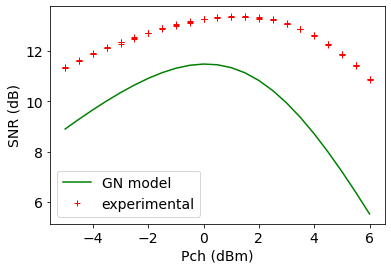

In [46]:
#plt.plot(pch, snr_simple, 'b-', label='simple model')
plt.plot(pch, snr_gn, 'g-', label='GN model')
plt.plot(pch, snr, 'r+', label='experimental')
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()